In [2]:
import pandas as pd
import yaml
import pandas as pd

with open("books.yaml", "r") as f:
    books_raw = yaml.safe_load(f)

books = pd.DataFrame([{k.lstrip(":"): v for k, v in d.items()} for d in books_raw])
users = pd.read_csv("users.csv")
orders = pd.read_parquet("orders.parquet")

In [4]:
books.head()

,id,title,author,genre,publisher,year
0,19199,The Yellow Meads of Asphodel,Carolyne West,Classic,Mainstream Publishing,2009
1,19398,From Here to Eternity,"Rep. Heath Stiedemann, Gino Welch, Haydee Larson",Short story,Vintage Books,2001
2,19483,Eyeless in Gaza,Vannessa Price,Biography/Autobiography,Pavilion Books,1886
3,19506,Precious Bane,Miss Yong Wyman,Realistic fiction,New English Library,2021
4,19570,City of God,Travis Moore,Suspense/Thriller,Bellevue Literary Press,1847


In [6]:
users.head()

,id,name,address,phone,email
0,44533,Hoyt Carter,"Apt. 300 8604 Ashlyn Wells, Effertzstad, ID 02997",(462) 385-4294,mckinley.rowe@harber.example
1,46128,Marco Kulas,"Apt. 538 816 Bechtelar Ferry, Lincolnhaven, KS...",913.466.4487,francisco@murray-cronin.test
2,46407,Denny Goyette LLD,"Apt. 174 39450 Mohr Rapids, Port Neomistad, AL...",(801) 970-3335,marguerita@wuckert.test
3,44602,Zackary Heller,"Apt. 608 74228 Bogan Valley, South Stepanieshi...",895.829.5417,annabelle@hessel.test
4,45828,Jess Beier,"2716 Jacobi Path, Ziemanntown, SC 65624-4660",(113) 784-3410,minh@hettinger.example


In [8]:
orders.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping
0,71389,47288,18976,2,27.00$,10/01/24 10:38:08 A.M.,None
1,66343,47049,19403,1,€50¢50,10:14;19-Oct-2024,"4940 Arnoldo Keys, West Arnette, KS 77599"
2,72606,46685,19500,1,USD 45.99,"22:13:35,2025-07-02",
3,68462,45336,18992,1,€ 71.00,2025-10-20 16:25:20,
4,72691,45311,19388,1,52.25 $,"08:48:47 A.M.,28-August-2024",None


In [11]:
books_copy = books.copy()
users_copy = users.copy()
orders_copy = orders.copy()

In [13]:
import pandas as pd
import yaml
import pyarrow.parquet as pq
import re
import numpy as np
from datetime import datetime

## Managing data and cleaning
## Users

In [16]:
for col in ["name", "address", "phone", "email"]:
    if col in users.columns:
        users[col] = users[col].astype(str).str.strip()
        
def normalize_phone(phone):
    if pd.isna(phone):
        return np.nan
    
    digits = re.sub(r"\D", "", str(phone))

    if len(digits) != 10:
        return np.nan  

    return f"{digits[0:3]}-{digits[3:6]}-{digits[6:10]}"

users["phone_clean"] = users["phone"].apply(normalize_phone)

users.head()

,id,name,address,phone,email,phone_clean
0,44533,Hoyt Carter,"Apt. 300 8604 Ashlyn Wells, Effertzstad, ID 02997",(462) 385-4294,mckinley.rowe@harber.example,462-385-4294
1,46128,Marco Kulas,"Apt. 538 816 Bechtelar Ferry, Lincolnhaven, KS...",913.466.4487,francisco@murray-cronin.test,913-466-4487
2,46407,Denny Goyette LLD,"Apt. 174 39450 Mohr Rapids, Port Neomistad, AL...",(801) 970-3335,marguerita@wuckert.test,801-970-3335
3,44602,Zackary Heller,"Apt. 608 74228 Bogan Valley, South Stepanieshi...",895.829.5417,annabelle@hessel.test,895-829-5417
4,45828,Jess Beier,"2716 Jacobi Path, Ziemanntown, SC 65624-4660",(113) 784-3410,minh@hettinger.example,113-784-3410


## Books

In [20]:
def split_authors(s):
    s = re.sub(r"[;&|]", ",", s)
    parts = [p.strip() for p in s.split(",") if p.strip() != ""]
    return parts

books_copy["author_list"] = books_copy["author"].apply(split_authors)
books_copy["author_set"] = books_copy["author_list"].apply(lambda x: frozenset(x))

books_copy.head()

,id,title,author,genre,publisher,year,author_list,author_set
0,19199,The Yellow Meads of Asphodel,Carolyne West,Classic,Mainstream Publishing,2009,[Carolyne West],(Carolyne West)
1,19398,From Here to Eternity,"Rep. Heath Stiedemann, Gino Welch, Haydee Larson",Short story,Vintage Books,2001,"[Rep. Heath Stiedemann, Gino Welch, Haydee Lar...","(Haydee Larson, Gino Welch, Rep. Heath Stiedem..."
2,19483,Eyeless in Gaza,Vannessa Price,Biography/Autobiography,Pavilion Books,1886,[Vannessa Price],(Vannessa Price)
3,19506,Precious Bane,Miss Yong Wyman,Realistic fiction,New English Library,2021,[Miss Yong Wyman],(Miss Yong Wyman)
4,19570,City of God,Travis Moore,Suspense/Thriller,Bellevue Literary Press,1847,[Travis Moore],(Travis Moore)


## Orders

In [24]:
import re
import pandas as pd
from dateutil import parser

def parse_timestamp(s):
    if pd.isna(s):
        return pd.NaT
    
    s = str(s).strip()
    
    s = s.replace("A.M.", "AM").replace("P.M.", "PM")
    s = s.replace("A.M", "AM").replace("P.M", "PM")
    s = s.replace("a.m.", "AM").replace("p.m.", "PM")
    s = s.replace("a.m", "AM").replace("p.m", "PM")
    s = s.replace("am", "AM").replace("pm", "PM")
    s = s.replace(";", " ").replace(",", " ")
    s = re.sub(r"\s+", " ", s)
    
    try:
        dt = parser.parse(s, dayfirst=False, fuzzy=True)
        return dt
    except Exception:
        return pd.NaT

In [26]:
orders_copy["timestamp_parsed"] = orders_copy["timestamp"].apply(parse_timestamp)
orders_copy["date"] = orders_copy["timestamp_parsed"].dt.date

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date
0,71389,47288,18976,2,27.00$,10/01/24 10:38:08 A.M.,None,2024-10-01 10:38:08,2024-10-01
1,66343,47049,19403,1,€50¢50,10:14;19-Oct-2024,"4940 Arnoldo Keys, West Arnette, KS 77599",2024-10-19 10:14:00,2024-10-19
2,72606,46685,19500,1,USD 45.99,"22:13:35,2025-07-02",,2025-07-02 22:13:35,2025-07-02
3,68462,45336,18992,1,€ 71.00,2025-10-20 16:25:20,,2025-10-20 16:25:20,2025-10-20
4,72691,45311,19388,1,52.25 $,"08:48:47 A.M.,28-August-2024",None,2024-08-28 08:48:47,2024-08-28


In [28]:
import re
import numpy as np
import pandas as pd

def parse_price(p):
    if pd.isna(p):
        return np.nan

    s = str(p).strip().replace(" ", "") 

    s = s.replace("¢", ".")

    if ("$" in s or "€" in s) and "." not in s:
        parts = re.split(r"[$€]", s)
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            value = float(parts[0] + "." + parts[1])
            return value if "$" in s else value * 1.2

    nums = re.findall(r"\d+(?:\.\d+)?", s)
    if not nums:
        return np.nan

    value = nums[0]

    if value.endswith("."):
        value = value[:-1]

    if value == "":
        return np.nan

    value = float(value)

    if "$" in s or "USD" in s.upper():
        return value

    if "€" in s or "EUR" in s.upper():
        return value * 1.2

    return np.nan

In [30]:
orders_copy["unit_price_usd"] = orders_copy["unit_price"].apply(parse_price)
orders_copy["paid_price"] = orders_copy["unit_price_usd"] * orders_copy["quantity"]

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,paid_price
0,71389,47288,18976,2,27.00$,10/01/24 10:38:08 A.M.,None,2024-10-01 10:38:08,2024-10-01,27.00,54.00
1,66343,47049,19403,1,€50¢50,10:14;19-Oct-2024,"4940 Arnoldo Keys, West Arnette, KS 77599",2024-10-19 10:14:00,2024-10-19,60.60,60.60
2,72606,46685,19500,1,USD 45.99,"22:13:35,2025-07-02",,2025-07-02 22:13:35,2025-07-02,45.99,45.99
3,68462,45336,18992,1,€ 71.00,2025-10-20 16:25:20,,2025-10-20 16:25:20,2025-10-20,85.20,85.20
4,72691,45311,19388,1,52.25 $,"08:48:47 A.M.,28-August-2024",None,2024-08-28 08:48:47,2024-08-28,52.25,52.25


In [34]:
users_clean = users.copy()
users_clean = users_clean.rename(columns={"id": "user_id"})

books_clean = books_copy.copy()
books_clean = books_clean.rename(columns={"id": "book_id"})

orders_clean = orders_copy.copy()

orders_users = orders_clean.merge(
    users_clean,
    on="user_id",
    how="left",
    suffixes=("", "_user")
)

full = orders_users.merge(
    books_clean,
    on="book_id",
    how="left",
    suffixes=("", "_book")
)

full.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,...,phone,email,phone_clean,title,author,genre,publisher,year,author_list,author_set
0,71389,47288,18976,2,27.00$,10/01/24 10:38:08 A.M.,None,2024-10-01 10:38:08,2024-10-01,27.00,...,761-056-4908,alexandria@herman.test,761-056-4908,Cinema Paradiso,Pres. Doug Donnelly,Fable,Oberon Books,0,[Pres. Doug Donnelly],(Pres. Doug Donnelly)
1,66343,47049,19403,1,€50¢50,10:14;19-Oct-2024,"4940 Arnoldo Keys, West Arnette, KS 77599",2024-10-19 10:14:00,2024-10-19,60.60,...,107-013-1615,heath@graham.test,107-013-1615,Of Human Bondage,Cassi Herman,Folklore,Parragon,1978,[Cassi Herman],(Cassi Herman)
2,72606,46685,19500,1,USD 45.99,"22:13:35,2025-07-02",,2025-07-02 22:13:35,2025-07-02,45.99,...,404 342 5576,dorsey@schimmel.test,404-342-5576,Hotel California,Delbert Emmerich II,Legend,Book League of America,1984,[Delbert Emmerich II],(Delbert Emmerich II)
3,68462,45336,18992,1,€ 71.00,2025-10-20 16:25:20,,2025-10-20 16:25:20,2025-10-20,85.20,...,112.073.0471,jared@schroeder.example,112-073-0471,Mother Night,Sondra O'Reilly,Folklore,Left Book Club,1978,[Sondra O'Reilly],(Sondra O'Reilly)
4,72691,45311,19388,1,52.25 $,"08:48:47 A.M.,28-August-2024",None,2024-08-28 08:48:47,2024-08-28,52.25,...,713-978-6789,damien@dickinson-ratke.example,713-978-6789,Raiders of the Lost Ark,Frankie Vandervort,Humor,Newnes,1981,[Frankie Vandervort],(Frankie Vandervort)


In [36]:
full.to_excel("full1.xlsx", index=False)
users.to_excel("users1.xlsx", index=False)

### Let's try to find the needed info based on the tasks

In [38]:
users.columns

Index(['id', 'name', 'address', 'phone', 'email', 'phone_clean'], dtype='object')

In [41]:
daily_revenue = (
    full.dropna(subset=["date"]) 
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

top5_days = daily_revenue.sort_values("daily_revenue", ascending=False).head(5)

print("Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA2):")
print(top5_days)
print()
#####################################################################################

# union-find
parent = {}

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for uid in users["id"]:
    parent[uid] = uid

fields = ["email", "phone_clean", "name", "address"]

for col in fields:
    groups = (
        users.dropna(subset=[col])
             .groupby(col)["id"]
             .apply(list)
    )
    for _, uids in groups.items():
        if len(uids) > 1:
            base = uids[0]
            for other in uids[1:]:
                union(base, other)

clusters = {}
for uid in users["id"]:
    root = find(uid)
    clusters.setdefault(root, []).append(uid)

num_real_users = len(clusters)
print("Number of unique users (real, reconciled) (DATA1):", num_real_users)
print()

#####################################################################################

num_author_sets = books_copy["author_set"].nunique()
print("Number of unique sets of authors (DATA1):", num_author_sets)
print()

#####################################################################################

author_popularity = (
    full.dropna(subset=["author_set"])
        .groupby("author_set")["quantity"]
        .sum()
        .sort_values(ascending=False)
)

top_author_set = author_popularity.index[0]
top_author_qty = author_popularity.iloc[0]

print("The most popular author(s) (DATA1):", list(top_author_set))
print("Number of sold books:", top_author_qty)
print()

#####################################################################################

user_to_real = {uid: find(uid) for uid in users["id"]}

full["real_user"] = full["user_id"].map(user_to_real)

spending = (
    full.groupby("real_user")["paid_price"]
        .sum()
        .sort_values(ascending=False)
)

best_real_user = spending.index[0]
best_buyer_aliases = clusters[best_real_user]

print("Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA1):", best_buyer_aliases)
print()

Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA2):
           date  daily_revenue
339  2025-01-02       3995.068
290  2024-11-14       3911.974
221  2024-09-06       3790.168
285  2024-11-09       3518.618
252  2024-10-07       3517.018

Number of unique users (real, reconciled) (DATA1): 2951

Number of unique sets of authors (DATA1): 325

The most popular author(s) (DATA1): ['Arlinda Huel']
Number of sold books: 201

Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA1): [46680, 46926, 44622, 44621, 47462, 46945, 44988, 45628, 44664, 46122, 45160, 47292, 45984, 44495, 45370, 46303, 47055, 46585, 47351, 47006, 47018, 46846, 47527, 45320, 46364, 44822, 47047, 47119, 47496, 46713, 44479, 46172, 45504, 45832, 47413, 45790, 47554, 45004, 45777, 46886, 45098, 46932, 44638, 46352, 46525, 44358, 46221, 46904, 46058, 45643, 47028, 46779, 46136, 44397, 47282, 45998, 45379, 44596, 46114, 45266, 44366, 45332, 47309, 45011, 47272, 46098, 47536, 44545, 46913, 46013, 44784

In [51]:
summary_data1 = pd.DataFrame({
    "metric": [
        "num_real_users",
        "num_author_sets",
        "most_popular_authors",
        "most_popular_authors_sold",
        "best_buyer_aliases"
    ],
    "value": [
        num_real_users,
        num_author_sets,
        ", ".join(list(top_author_set)),
        top_author_qty,
        str(best_buyer_aliases)
    ]
})

summary_data2.to_excel("DATA1_summary_metrics.xlsx", index=False)

In [67]:
alias_spending = (
    full[full["user_id"].isin(best_buyer_aliases)]
        .groupby("user_id", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "alias_spent"})
)

best_buyer_table = (
    alias_spending
        .merge(users, left_on="user_id", right_on="id", how="left")
        .sort_values("alias_spent", ascending=False)
)

best_buyer_table.to_excel("DATA1_best_buyer_aliases.xlsx", index=False)

In [65]:
top_author_sets = (
    full.dropna(subset=["author_set"])
        .groupby("author_set", as_index=False)["quantity"]
        .sum()
        .rename(columns={"quantity": "sold_books"})
        .sort_values("sold_books", ascending=False)
)

top_author_sets10 = top_author_sets.copy()
top_author_sets10["authors"] = top_author_sets10["author_set"].apply(lambda s: ", ".join(sorted(list(s))))
top_author_sets10 = top_author_sets10[["authors", "sold_books"]]

top_author_sets10.to_excel("DATA1_top_author_sets10.xlsx", index=False)

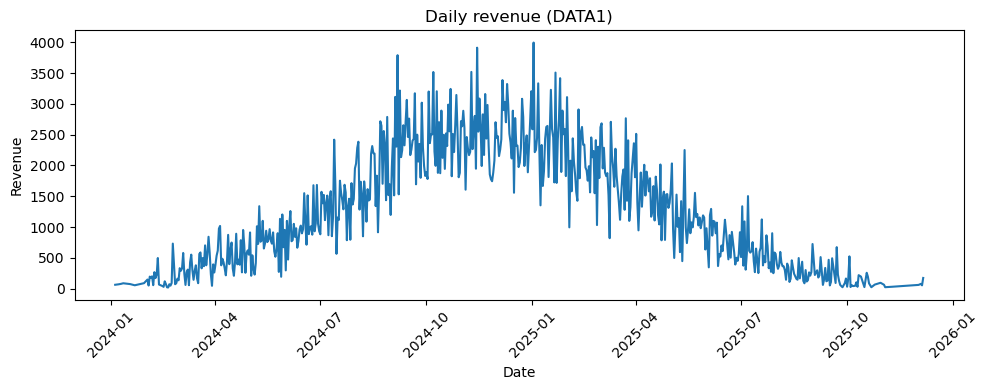

In [49]:
import matplotlib.pyplot as plt

daily_revenue = (
    full.dropna(subset=["date"])              
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

plt.figure(figsize=(10, 4))
plt.plot(daily_revenue["date"], daily_revenue["daily_revenue"])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Daily revenue (DATA1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()